<a href="https://colab.research.google.com/github/Ayush-Tibrewal/Brain-Stroke-Prediction/blob/main/BRAIN_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from tensorflow.keras import metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import numpy as np
from tqdm import tqdm
import cv2
import os
import statistics
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, NASNetLarge, DenseNet201, EfficientNetV2S, MobileNet, ResNet152, InceptionV3, Xception
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from keras.models import Model, Sequential
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
plt.style.use('seaborn')
RANDOM_SEED = 123


<ipython-input-2-9ae99a4bc05e>:43: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

IMG_PATH = '/content/drive/MyDrive/Classroom/brain_tumor_dataset/'

# Create directories for train, validation, and test sets if they don't exist
os.makedirs('TRAIN', exist_ok=True)
os.makedirs('VAL', exist_ok=True)
os.makedirs('TEST', exist_ok=True)

# Define the split ratios
test_ratio = 0.1  # 10% of the data for the test set
val_ratio = 0.1   # 10% of the data for the validation set

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        class_path = os.path.join(IMG_PATH, CLASS)
        if os.path.isdir(class_path):
            # Get the list of image files in the class directory
            img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            # Create directories for each class
            os.makedirs(os.path.join('TRAIN', CLASS.upper()), exist_ok=True)
            os.makedirs(os.path.join('VAL', CLASS.upper()), exist_ok=True)
            os.makedirs(os.path.join('TEST', CLASS.upper()), exist_ok=True)

            # Split the data into train, validation, and test sets
            train_files, test_val_files = train_test_split(img_files, test_size=(test_ratio + val_ratio), random_state=42)
            val_files, test_files = train_test_split(test_val_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

            # Copy the files to the respective directories
            for file_name in train_files:
                shutil.copy(os.path.join(class_path, file_name), os.path.join('TRAIN', CLASS.upper(), file_name))
            for file_name in val_files:
                shutil.copy(os.path.join(class_path, file_name), os.path.join('VAL', CLASS.upper(), file_name))
            for file_name in test_files:
                shutil.copy(os.path.join(class_path, file_name), os.path.join('TEST', CLASS.upper(), file_name))


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

TRAIN_DIR = '/content/drive/MyDrive/Classroom/brain_tumor_dataset/TRAIN/'
TEST_DIR = '/content/drive/MyDrive/Classroom/brain_tumor_dataset/TEST/'
VAL_DIR = '/content/drive/MyDrive/Classroom/brain_tumor_dataset/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]
<ipython-input-17-a97563ab283d>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



202 images loaded from /content/drive/MyDrive/Classroom/brain_tumor_dataset/TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


26 images loaded from /content/drive/MyDrive/Classroom/brain_tumor_dataset/TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 17.33it/s]

25 images loaded from /content/drive/MyDrive/Classroom/brain_tumor_dataset/VAL/ directory.


In [ ]:
X_test.size

26

In [ ]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

# Assuming you have already calculated the counts in the y_train, y_val, and y_test variables

y = {0: [], 1: []}
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

fig = make_subplots(rows=1, cols=1)

fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)

fig.update_layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
)

init_notebook_mode(connected=True)
iplot(fig)


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

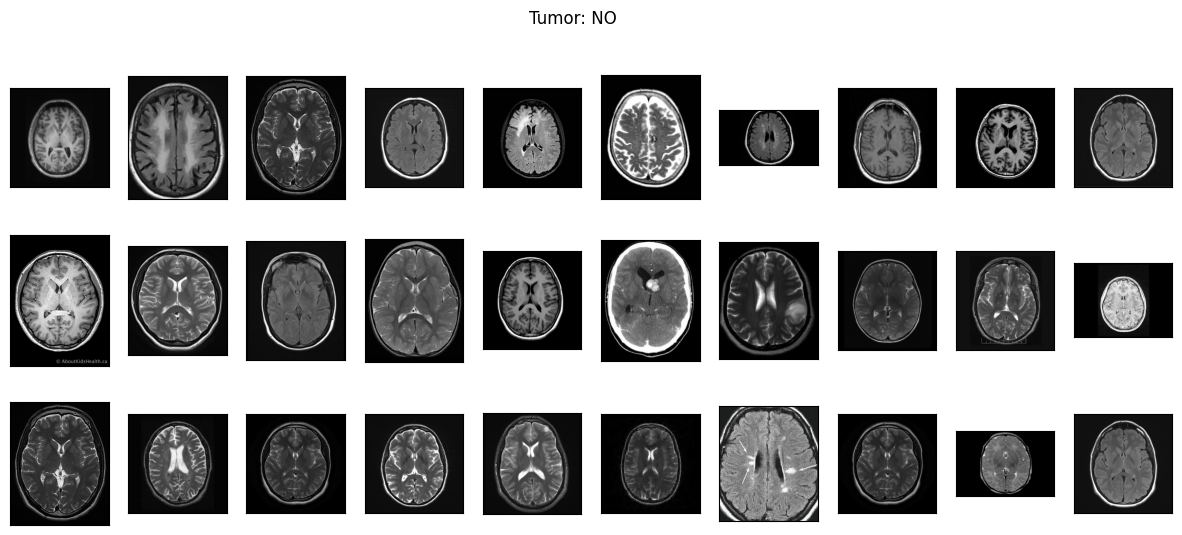

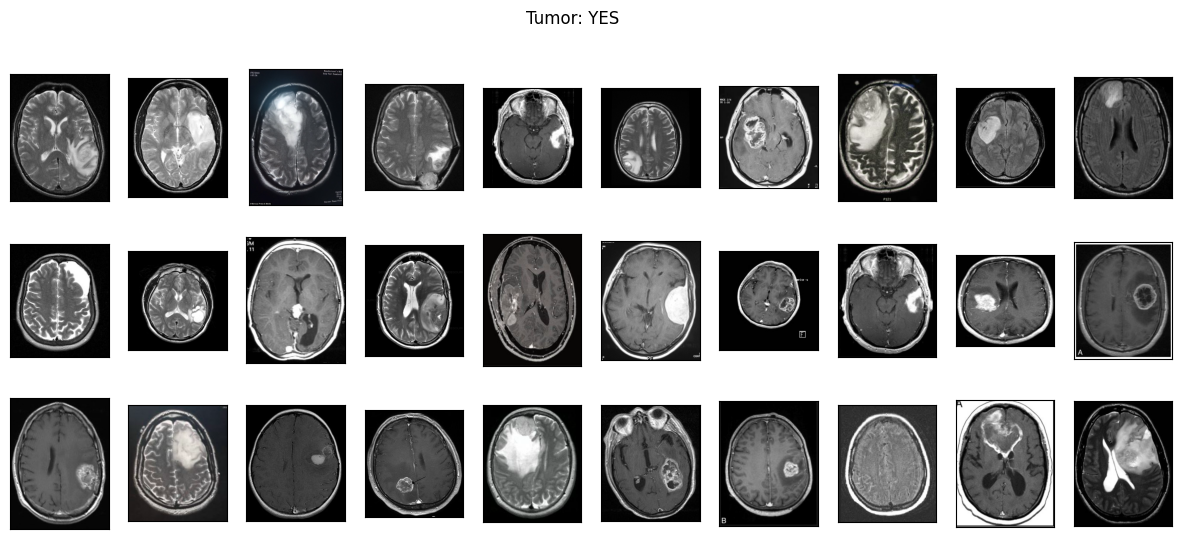

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Classroom/brain_tumor_dataset/TRAIN/YES/Y1.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

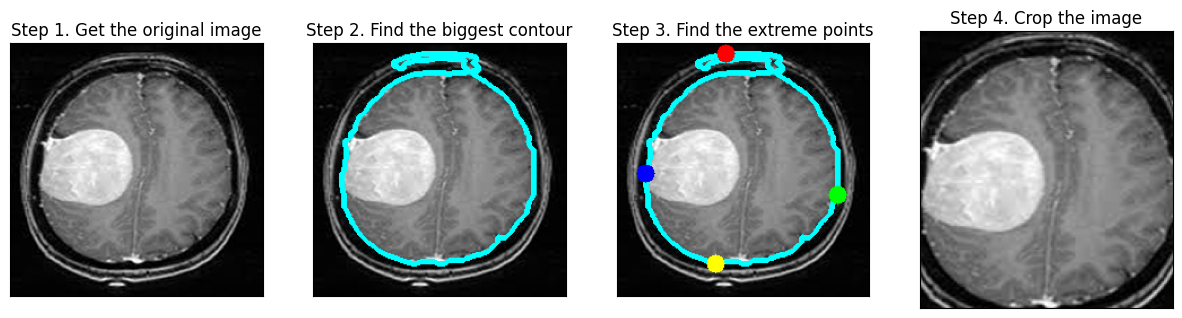

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


<ipython-input-30-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



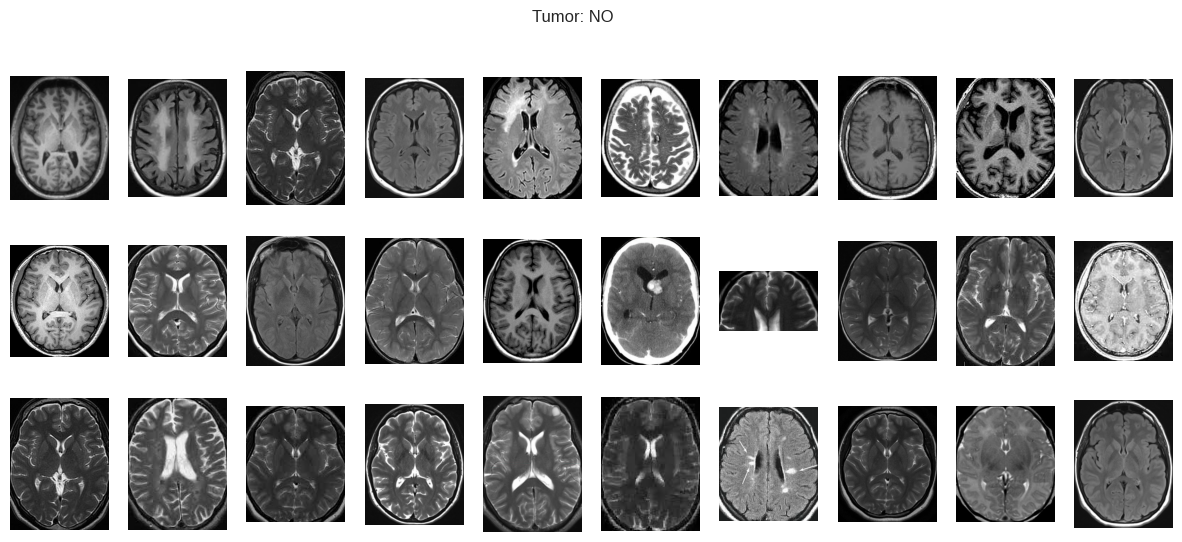

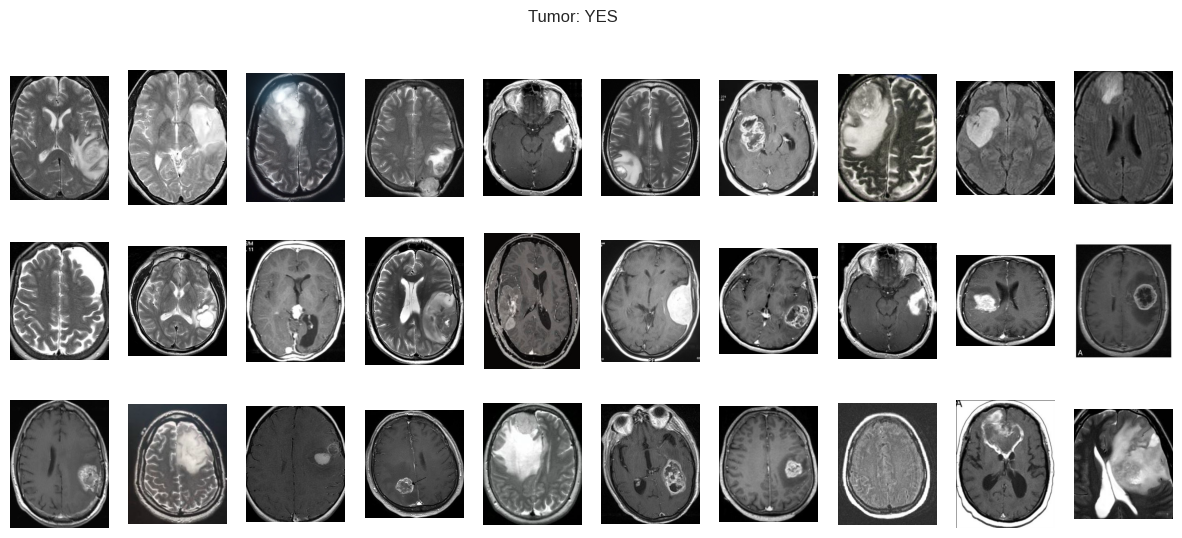

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
import cv2

def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        try:
            if imclass == 0:
                cv2.imwrite(folder_name + 'NO/' + str(i) + '.jpg', img)
            else:
                cv2.imwrite(folder_name + 'YES/' + str(i) + '.jpg', img)
            i += 1
        except Exception as e:
            print(f"Error saving image {i}: {str(e)}")




In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import statistics
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, NASNetLarge, DenseNet201, EfficientNetV2S, MobileNet, ResNet152, InceptionV3, Xception
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from keras.models import Model, Sequential
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
plt.style.use('seaborn')
RANDOM_SEED = 123

<ipython-input-4-afbf3980e57b>:17: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [ ]:
def load_data(dir_path, img_size=(256,256)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:

TRAIN_DIR = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TRAIN/'
TEST_DIR = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TEST/'
IMG_SIZE = (256,256)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:36<00:00, 18.47s/it]


1473 images loaded from /content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TRAIN/ directory.


100%|██████████| 3/3 [00:51<00:00, 17.01s/it]

185 images loaded from /content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TEST/ directory.


In [ ]:
print(len(os.listdir(TRAIN_DIR + "NORMAL")))
print(len(os.listdir(TRAIN_DIR + "STROKE")))
print(len(os.listdir(TEST_DIR + "NORMAL")))
print(len(os.listdir(TEST_DIR + "STROKE")))

869
604
109
76


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(20,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]), fontsize = 10)
        plt.show()


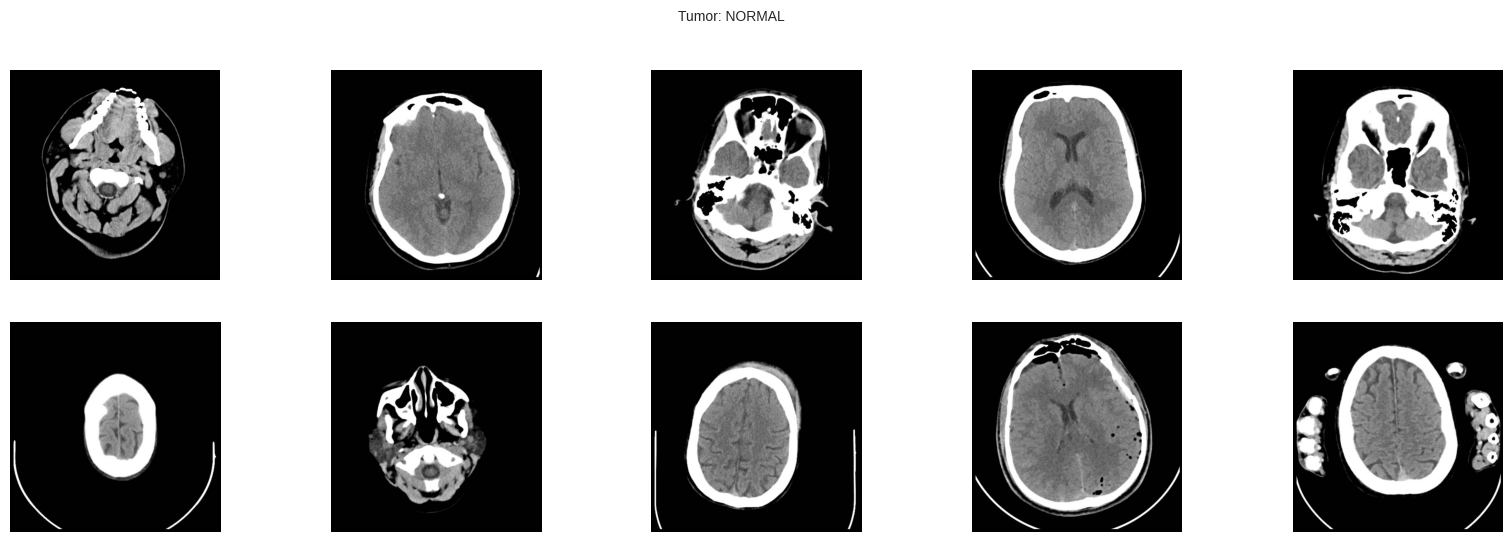

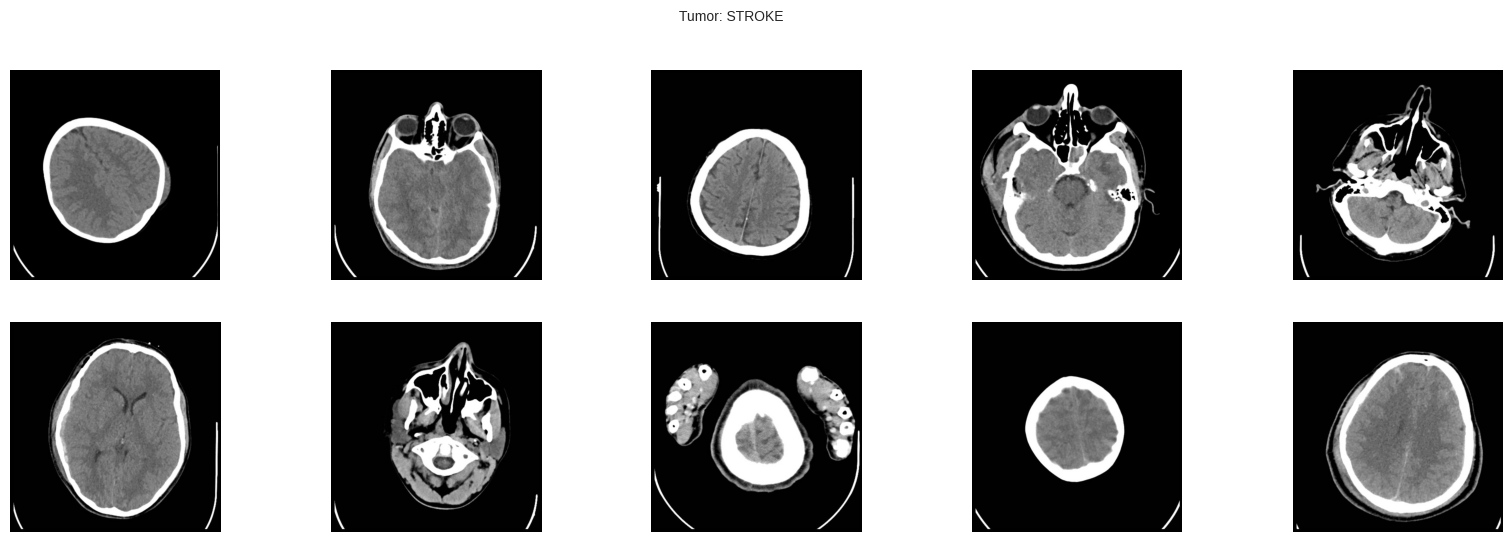

In [ ]:
plot_samples(X_train, y_train, labels, 10)

In [ ]:
import os

# Specify the directory paths for train and test
train_directory_path = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TRAIN/'
test_directory_path = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TEST/'

# List subdirectories (classes) for train
train_classes = [class_name for class_name in os.listdir(train_directory_path) if os.path.isdir(os.path.join(train_directory_path, class_name)) and class_name != '.ipynb_checkpoints']

# List subdirectories (classes) for test
test_classes = [class_name for class_name in os.listdir(test_directory_path) if os.path.isdir(os.path.join(test_directory_path, class_name)) and class_name != '.ipynb_checkpoints']

# Print the lists of classes for train and test
print("Train Classes:", train_classes)
print("Test Classes:", test_classes)


Train Classes: ['NORMAL', 'STROKE']
Test Classes: ['NORMAL', 'STROKE']


In [ ]:
import cv2
from tqdm import tqdm
import numpy as np

X = []
y = []
image_size = 256

# For the train directory
train_directory = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TRAIN/'
for class_name in train_classes:  # Assuming train_classes contains the list of classes
    folderPath = os.path.join(train_directory, class_name)
    for file_name in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, file_name))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(class_name)

# For the test directory
test_directory = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TEST/'
for class_name in test_classes:  # Assuming test_classes contains the list of classes
    folderPath = os.path.join(test_directory, class_name)
    for file_name in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, file_name))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(class_name)

X = np.array(X)
y = np.array(y)


100%|██████████| 76/76 [00:00<00:00, 164.60it/s]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Define a list of unique classes
Classes = list(set(y))

# Convert training labels to one-hot encoded vectors
y_train = np.array([Classes.index(label) for label in y_train])
y_train = keras.utils.to_categorical(y_train, num_classes=len(Classes))

# Convert testing labels to one-hot encoded vectors
y_test = np.array([Classes.index(label) for label in y_test])
y_test = keras.utils.to_categorical(y_test, num_classes=len(Classes))


In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=25,
    rescale = 1./255,
    horizontal_flip=True)
img_datagen.fit(X_train)
img_datagen.fit(X_test)

In [ ]:
def exponential_decay(lr, s):
    def exponential_decay_fn(epoch):
        return lr * 0.01
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.1, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

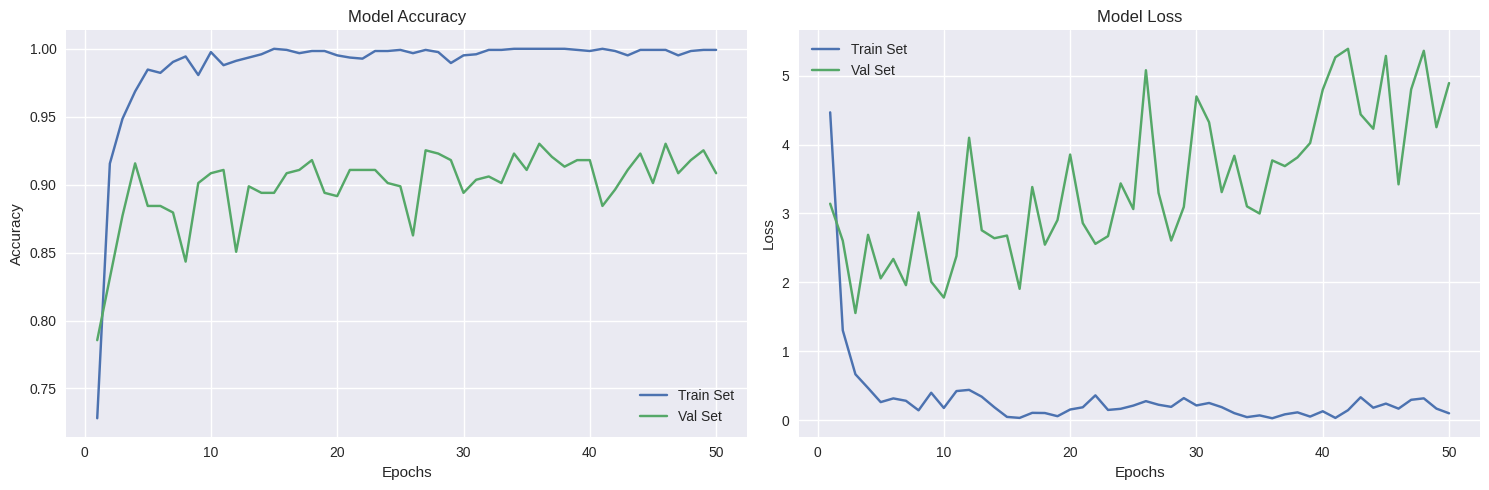

0.9876588916778565
0.31367222018539903
0.8997590363025665
3.4141625475883486
13/13 [==============================] - 2s 188ms/step


In [ ]:
VGGmodel = VGG19(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = VGGmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=VGGmodel.input, outputs=outputs)

for layers in VGGmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 50,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
#model.save('VGG19.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)


In [ ]:
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for VGG19 model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='VGG19')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

74836368/74836368 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


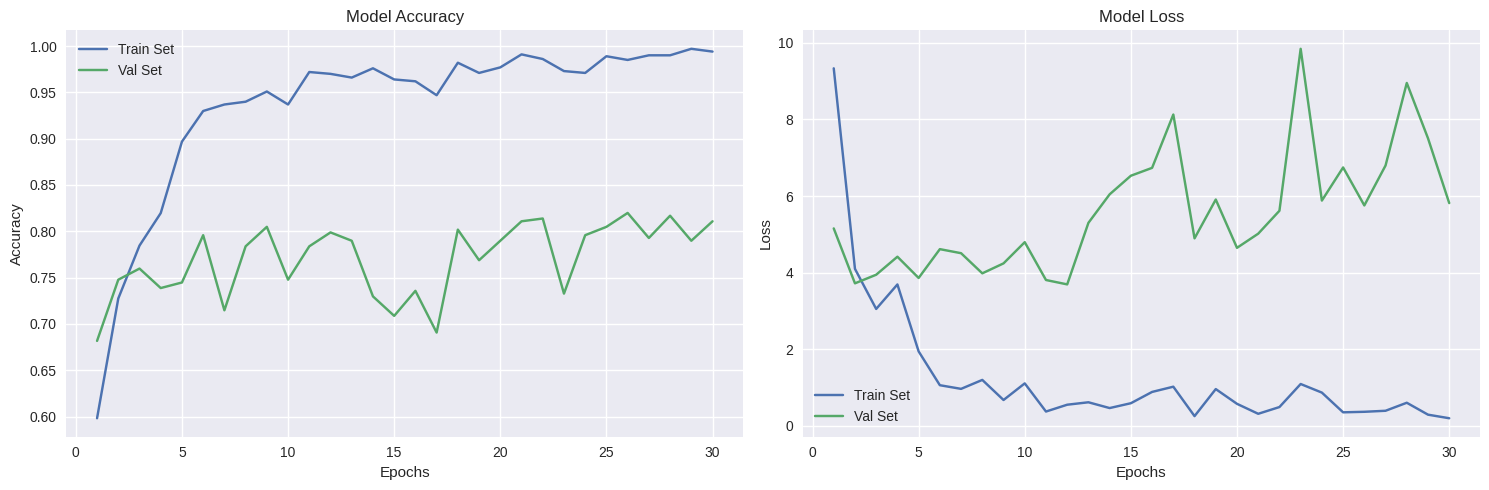

0.9357715447743734
1.2823038523395855
0.7701701660950978
5.561399523417155
11/11 [==============================] - 9s 157ms/step
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       167
           1       0.81      0.82      0.81       166

    accuracy                           0.81       333
   macro avg       0.81      0.81      0.81       333
weighted avg       0.81      0.81      0.81       333

The AUC score for DenseNet model is 0.8421650674554506


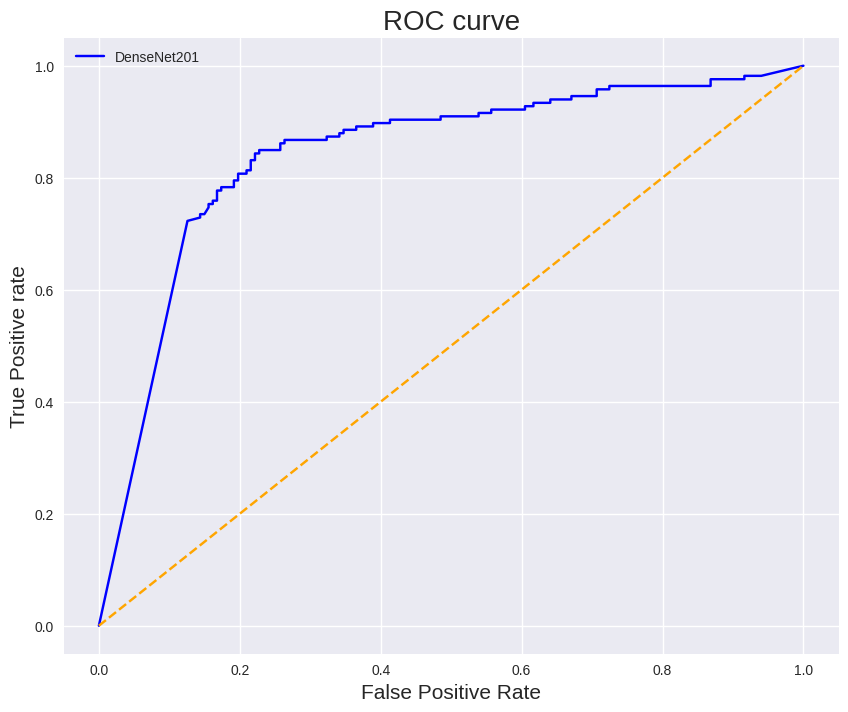

In [ ]:
DenseNetmodel = DenseNet201(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = DenseNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=DenseNetmodel.input, outputs=outputs)

for layers in DenseNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('DenseNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for DenseNet model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='DenseNet201')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();


In [ ]:
EfficientNetmodel = EfficientNetV2S(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = EfficientNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=EfficientNetmodel.input, outputs=outputs)

for layers in EfficientNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)

model.save('EfficientNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Efficient Net model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='EfficientNetV2S')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
import pandas as pd

Found 1473 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


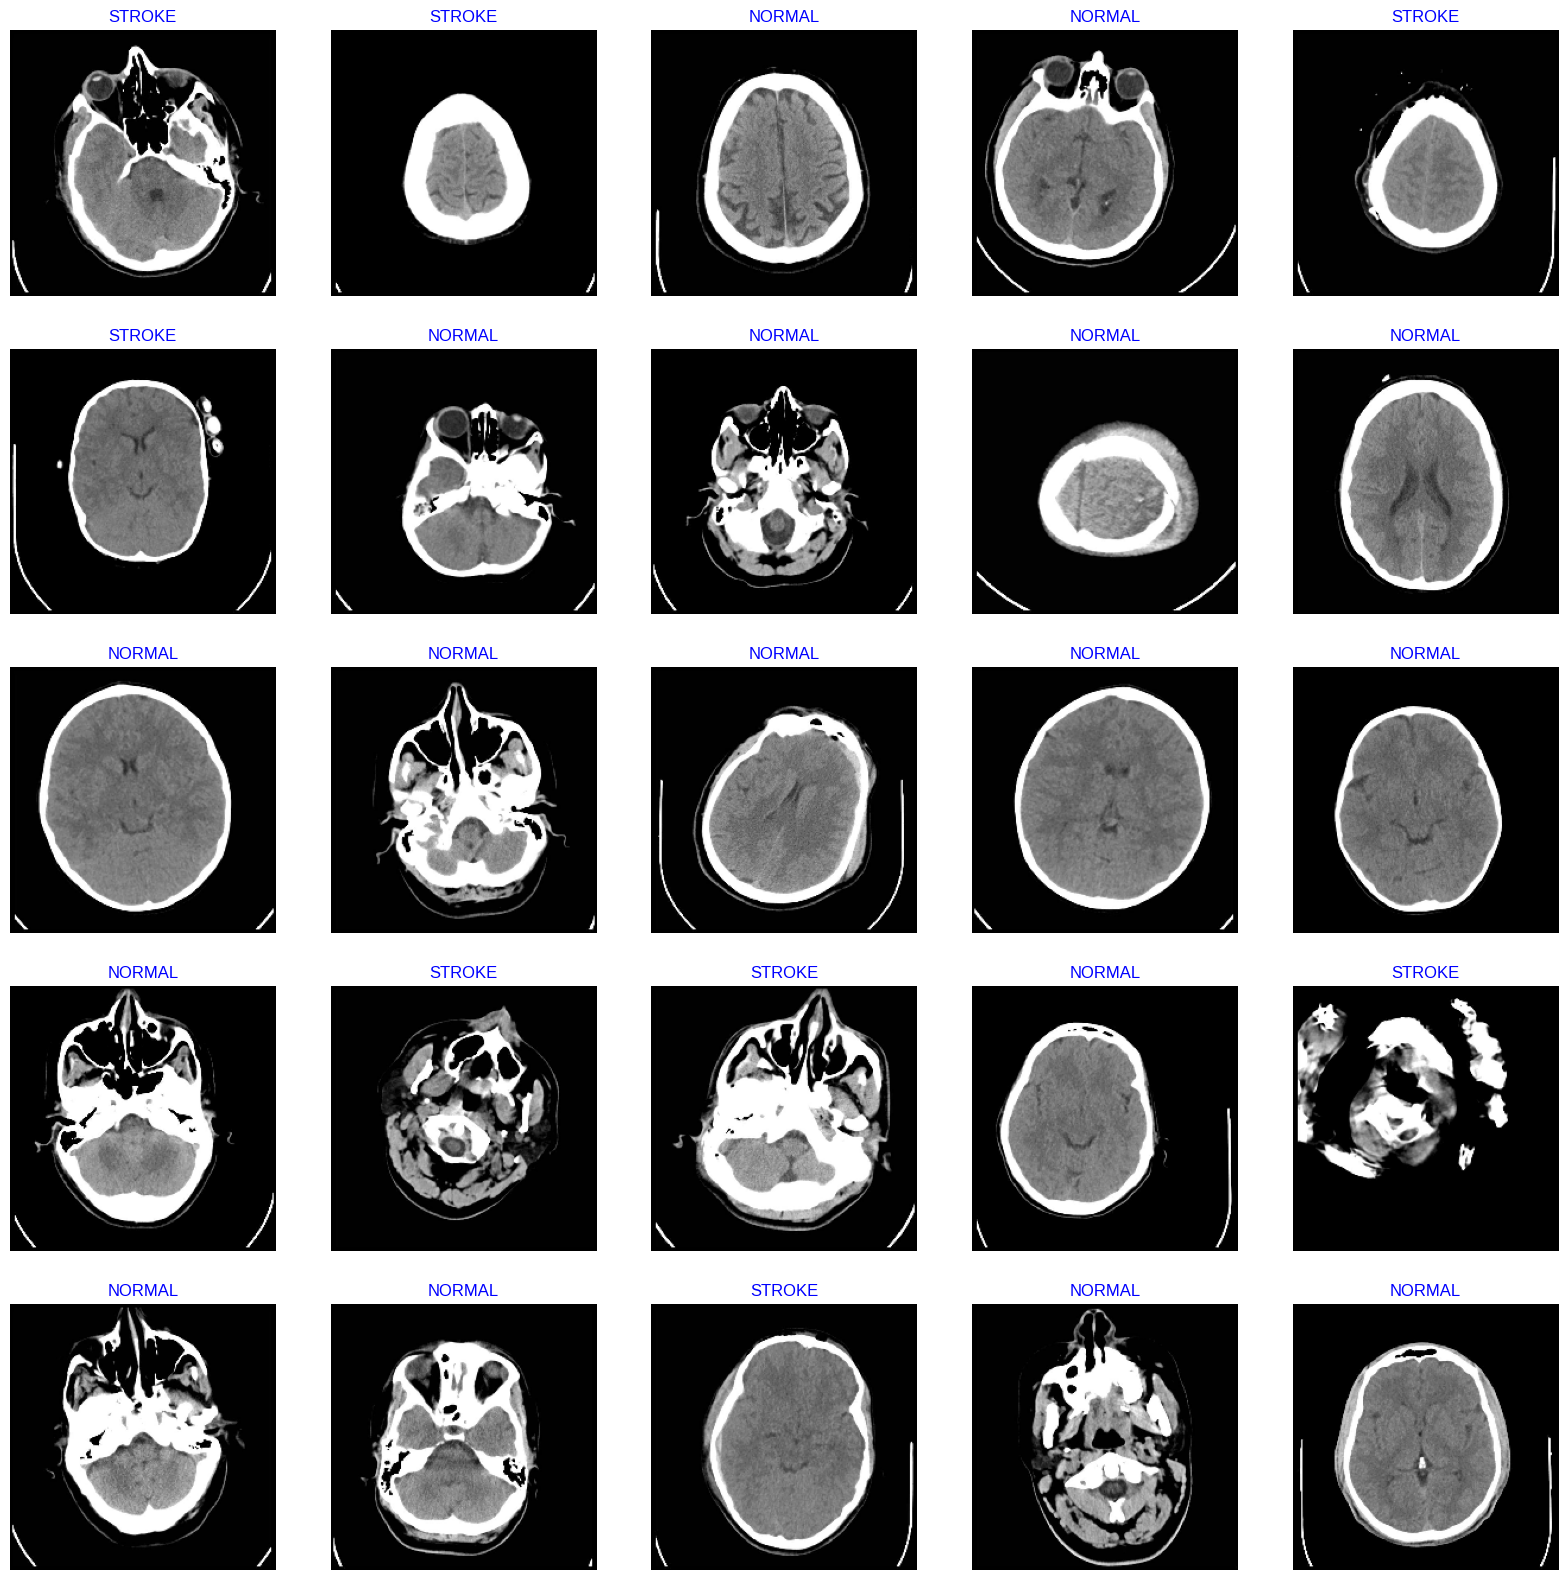

In [ ]:
# Get Dataframes
train_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TRAIN'
valid_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/VAL'
test_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/TEST'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [ ]:
!pip install --upgrade tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adamax

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_92 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_94 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                

In [ ]:
history = model.fit(x= train_gen, epochs= 40, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False, initial_epoch= 0)

Epoch 1/40
37/37 [==============================] - 173s 5s/step - loss: 35.5495 - accuracy: 0.5764 - val_loss: 0.6874 - val_accuracy: 0.5892
Epoch 2/40
37/37 [==============================] - 20s 532ms/step - loss: 0.6798 - accuracy: 0.5900 - val_loss: 0.6808 - val_accuracy: 0.5892
Epoch 3/40
37/37 [==============================] - 20s 544ms/step - loss: 0.6590 - accuracy: 0.6062 - val_loss: 0.6051 - val_accuracy: 0.6973
Epoch 4/40
37/37 [==============================] - 21s 561ms/step - loss: 0.6260 - accuracy: 0.6524 - val_loss: 0.5958 - val_accuracy: 0.6973
Epoch 5/40
37/37 [==============================] - 21s 566ms/step - loss: 0.5939 - accuracy: 0.6945 - val_loss: 0.6115 - val_accuracy: 0.5784
Epoch 6/40
37/37 [==============================] - 21s 557ms/step - loss: 0.6004 - accuracy: 0.6585 - val_loss: 0.5698 - val_accuracy: 0.7135
Epoch 7/40
37/37 [==============================] - 22s 585ms/step - loss: 0.5474 - accuracy: 0.7149 - val_loss: 0.5461 - val_accuracy: 0.7243


In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 32s 8s/step - loss: 0.0387 - accuracy: 0.9892
Train Loss:  0.001121704699471593
Train Accuracy:  1.0
--------------------
Validation Loss:  0.15778468549251556
Validation Accuracy:  0.9567567706108093
--------------------
Test Loss:  0.038735780864953995
Test Accuracy:  0.9891892075538635


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-51-01135dd8c8ed>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


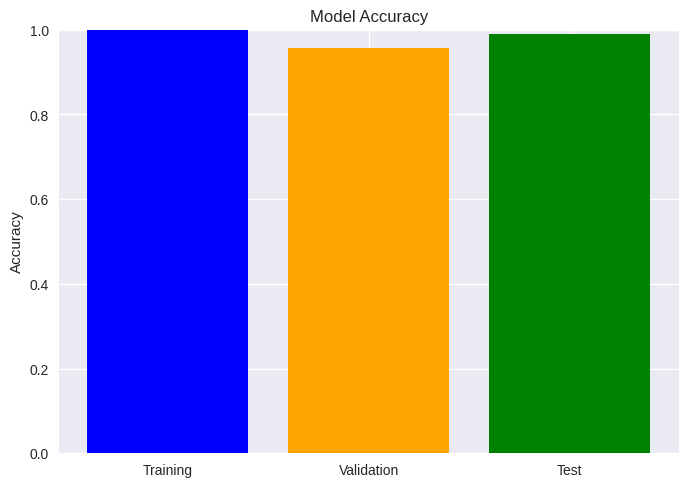

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics and values
metrics = ['Training', 'Validation', 'Test']
accuracies = [train_score[1], valid_score[1], test_score[1]]

# Create a bar plot
plt.bar(metrics, accuracies, color=['blue', 'orange', 'green'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1 for accuracy
plt.show()


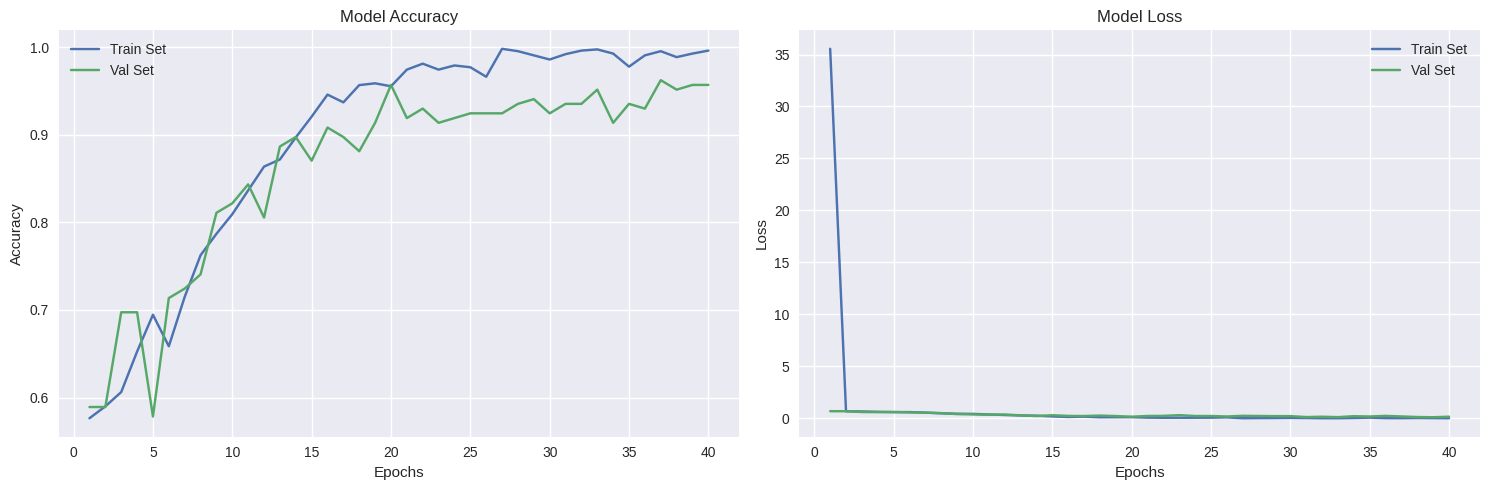

In [ ]:
# Assuming you have the 'history' object that contains training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


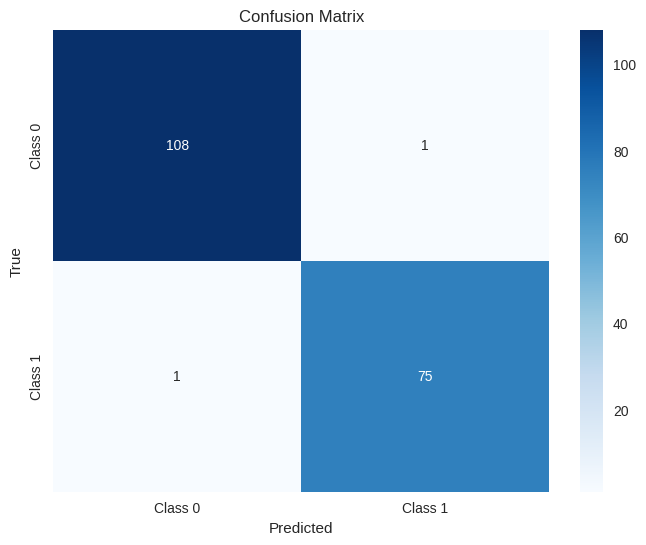

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Replace 'my_model.h5' with the name you want to give your model file
model.save('/content/drive/MyDrive/Projects/STROKE PREDICTION/my_model.h5', save_format='h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


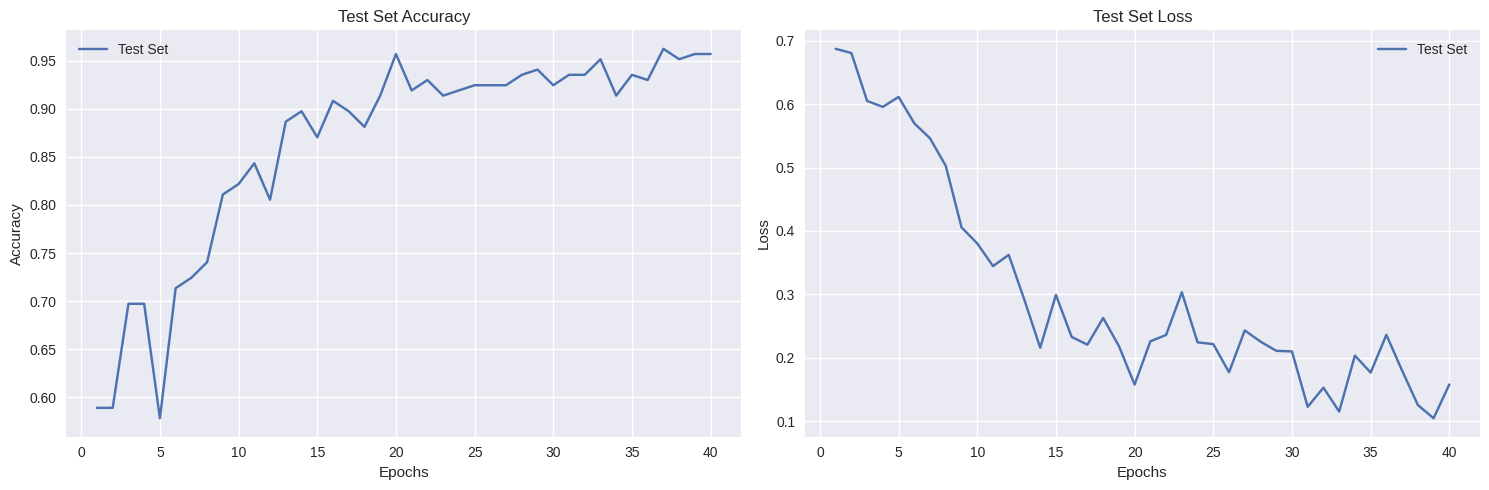

In [ ]:
# Assuming you have the 'history' object for the test set that contains test history
test_acc = history.history['val_accuracy']  # Use the validation accuracy for the test set
test_loss = history.history['val_loss']  # Use the validation loss for the test set

epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel ('Loss')
plt.title('Test Set Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the mean values for accuracy and loss
print("Mean Training Accuracy:", statistics.mean(acc))
print("Mean Training Loss:", statistics.mean(loss))
print("Mean Validation Accuracy:", statistics.mean(val_acc))
print("Mean Validation Loss:", statistics.mean(val_loss))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Calculate ROC curve and AUC score
pred_prob = model.predict_on_batch(X_test)
fpr, tpr, thresh = roc_curve(y_test.argmax(axis=1), pred_prob[:, 1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score = roc_auc_score(y_test.argmax(axis=1), pred_prob[:, 1])

print("The AUC score for your model is", auc_score)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle=None, color='blue', label='Your Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve', size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive rate', size=15)
plt.legend()
plt.savefig('ROC', dpi=700)  # Save the ROC curve plot
plt.show()


### NEW TRY

In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image dimensions
height = 299
width = 299

# Define the paths for your datasets
train_data_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/NON_CROPPED/TRAIN'
val_data_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/NON_CROPPED/VAL'

# Create data generators for training and validation data with more data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,  # Increase rotation for more data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height, width),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_ds = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height, width),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Create and compile the InceptionV3-based model with dropout and regularization
tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model_inceptionv3.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['acc']
)

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

NUM_EPOCHS = 50  # You can increase the number of epochs
model_inceptionv3.fit(train_ds, epochs=NUM_EPOCHS, validation_data=val_ds, callbacks=[early_stopping])
